In [22]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [23]:
def getMPPSignalPlot(exp_no, tag1, tag2, freq, processedDF):
    # freq in mhz
    plt.subplot(2,1,1)
    v1=processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag1) & (processedDF['Tx']==tag2) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0]
    plt.plot(v1)
    plt.ylim([np.percentile(v1,1), np.percentile(v1,99)])
    plt.title(f"Rx={tag1}, Tx={tag2}")
    
    plt.subplot(2,1,2)
    v2=processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag2) & (processedDF['Tx']==tag1) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0]
    plt.plot(v2)
    plt.ylim([np.percentile(v2,1), np.percentile(v2,99)])
    plt.title(f"Rx={tag2}, Tx={tag1}")
    
    plt.suptitle(f"Exp={exp_no}, freq={freq}")
    plt.tight_layout()
    plt.show()
    
    return v1, v2

In [24]:
steps=[1,2,3,4]
# steps=[1]

In [25]:
with open(f'distances.pkl', 'rb') as f:
    all_distances=pickle.load(f)
    

In [26]:
all_phase_info={}
for step in steps:
    with open(f"Step{step}/no_correction_all_phases.pkl", 'rb') as f:
        all_phase_info[step] = pickle.load(f)

In [27]:
all_voltage_dfs={}
for step in steps:
    with open(f"Step{step}/processedDF.pkl", 'rb') as f:
        all_voltage_dfs[step] = pickle.load(f)

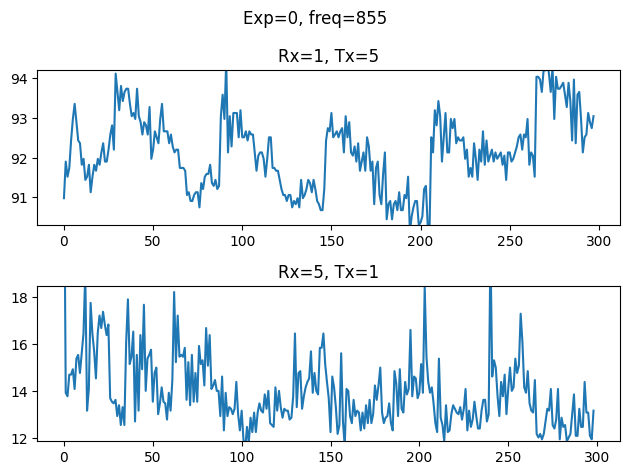

In [28]:
step=1
v1,v2=getMPPSignalPlot(exp_no=0, tag1=1, tag2=5, freq=855, processedDF=all_voltage_dfs[step])

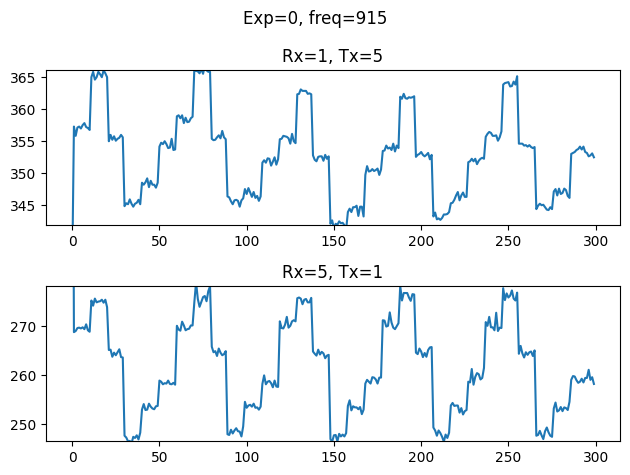

In [29]:
step=1
v1,v2=getMPPSignalPlot(exp_no=0, tag1=1, tag2=5, freq=915, processedDF=all_voltage_dfs[step])

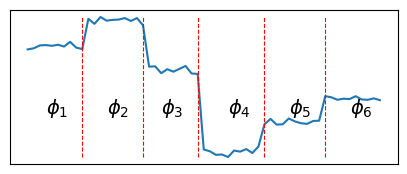

In [30]:
plt.figure(figsize=(5,2))
plt.plot(v2[1:60])
plt.xticks([])
plt.yticks([])
for idx,i in enumerate([9,19,28, 39, 49]):
    plt.vlines(i,min(v2[1:60]),max(v2[1:60]), linestyles='--', colors='red', linewidth=0.8)
    plt.text(i-6, 255, f"$\phi_{idx+1}$", fontsize=14)
plt.text(i+4, 255, f"$\phi_{idx+2}$", fontsize=14)
plt.savefig("demo.svg")

In [31]:
# list(all_phase_info[1].keys())[8:19]

In [101]:
def plot_phases(step, exps:list, links:list, start_freq_idx=8, end_freq_idx=19):
    global all_distances, all_phase_info, all_freqs
    plt.figure(figsize=(10,6))
    link_wise_ph={}
    all_freqs=list(all_phase_info[step].keys())[start_freq_idx:end_freq_idx]
    phase_theoretical=[]
    
    
    
    dists=[]
    for link_idx,link in enumerate(links):
        try:
            dists.append(np.round(all_distances[step][exps[link_idx]][link],4))
        except:
            print(f"{link_idx}, {link} not found in exps")
            dists.append(0.4)
        if link not in link_wise_ph:
            link_wise_ph[link]=[]
        for freq in all_freqs:
            link_wise_ph[link].append(all_phase_info[step][freq][exps[link_idx]][0][link])
            if len(links)==1:
                wavelength=3e8/freq
                phase_theoretical.append((2*np.pi* dists[0] / wavelength) % (np.pi))
        link_wise_ph[link]=np.array(link_wise_ph[link])
        

    plt.subplot(2,1,1)
    title_string=""
    for link_idx,link in enumerate(links):
        plt.plot(all_freqs,np.rad2deg(link_wise_ph[link]), '.-', label=f"{link}, exp {exps[link_idx]}")
        title_string+=f"Exp{exps[link_idx]}, link:{link}, dist:{dists[link_idx]}; "
    if len(links)==1:
        plt.plot(all_freqs, np.rad2deg(phase_theoretical))
        
    plt.legend()
    plt.xticks(np.arange(all_freqs[0],all_freqs[-1]+1, 10e6))
    plt.ylim([0,185])
    plt.xlabel("Freq (Hz)")
    plt.ylabel("Phase (rad)")
    plt.yticks(np.arange(0,181,10))
    plt.grid()
    
    plt.title(title_string)
    if len(links)==2:
        plt.subplot(2,1,2)
        plt.plot(all_freqs, np.abs(np.rad2deg(link_wise_ph[links[0]]-link_wise_ph[links[1]])), label=f"abs(ph_{links[0]} - ph_{links[1]})")
        plt.ylabel("Abs delta phase")
        plt.ylim([0,185])
        plt.legend()
        plt.grid()
        plt.xticks(np.arange(all_freqs[0],all_freqs[-1]+1, 10e6))
        plt.yticks(np.arange(0,181,10))
        plt.tight_layout()
        plt.show()
    return link_wise_ph, phase_theoretical

In [33]:
def plot_phase_freq_wise(step_exp_links: list, freqs: list):
    global all_distances, all_phase_info, all_freqs
    plt.figure(figsize=(10,3*len(freqs)))
    for freq_idx, freq in enumerate(freqs):
        ph_lst=[]
        label_lst=[]
        for step, exp, link in step_exp_links:
            ph_lst.append(all_phase_info[step][freq][exp][0][link])
            label_lst.append(f"S{step}_E{exp}_{link}\nD={np.round(all_distances[step][exp][link],4)}")
        
        plt.subplot(len(freqs),1,freq_idx+1)
        plt.plot(np.rad2deg(ph_lst), marker='o')   # plot values
        plt.xticks(ticks=range(len(ph_lst)), labels=label_lst)  # set custom labels
        plt.ylim([0, 181])
        plt.yticks(np.arange(0,181,20))
        plt.xlabel("Labels")
        plt.ylabel("Phase [deg]")
        plt.grid(True)
        plt.title(freq)
    
    plt.tight_layout()
    plt.show()

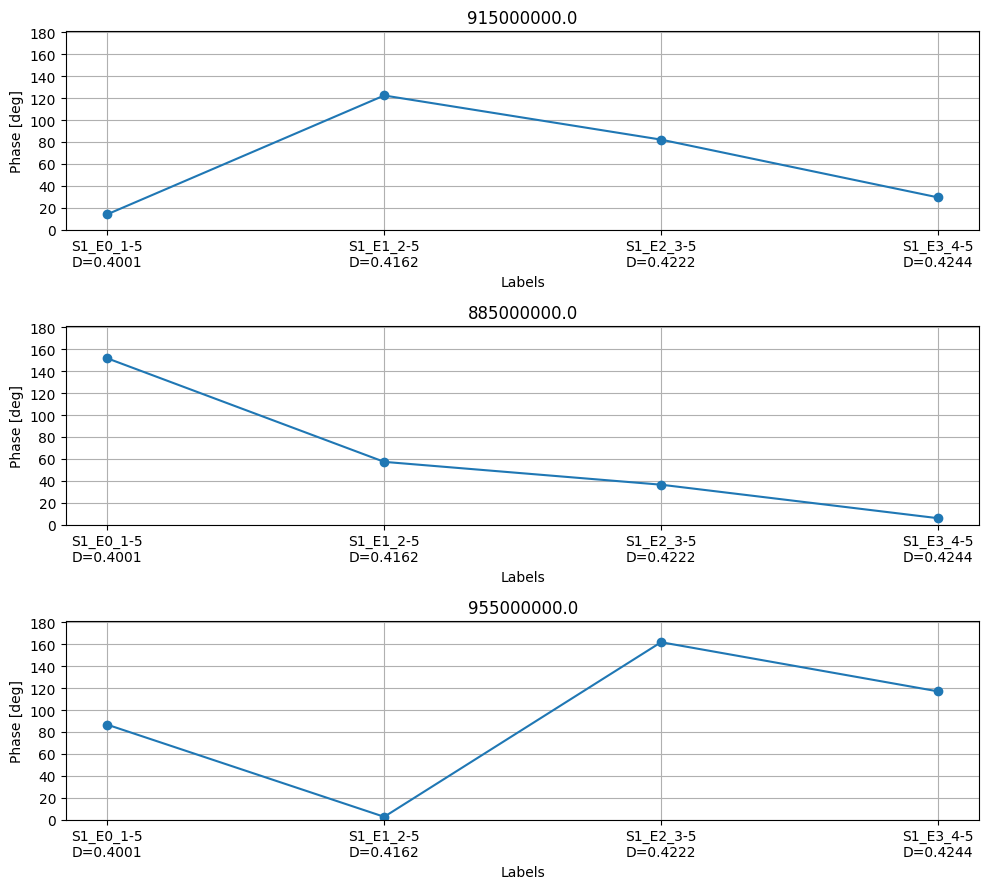

In [34]:
plot_phase_freq_wise(step_exp_links = [
                        (1, 0, '1-5'),
                        (1, 1, '2-5'),
                        (1, 2, '3-5'),
                        (1, 3, '4-5'),
                    ],
                    freqs= [915e6, 885e6, 955e6])

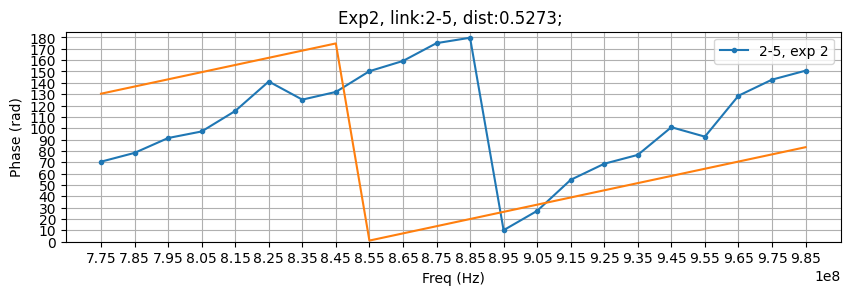

In [43]:
plot_phases(step=1, exps=[2], links=['2-5'], start_freq_idx=0, end_freq_idx=-1)


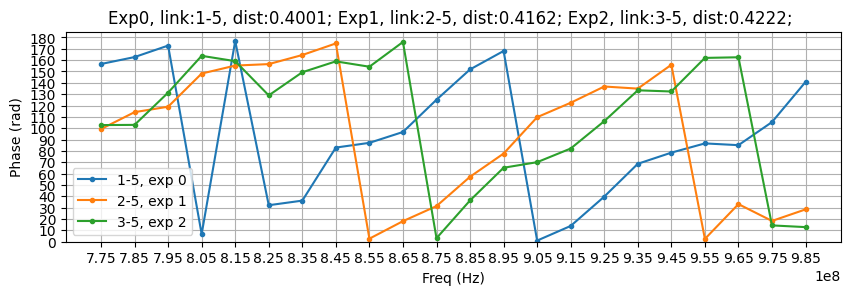

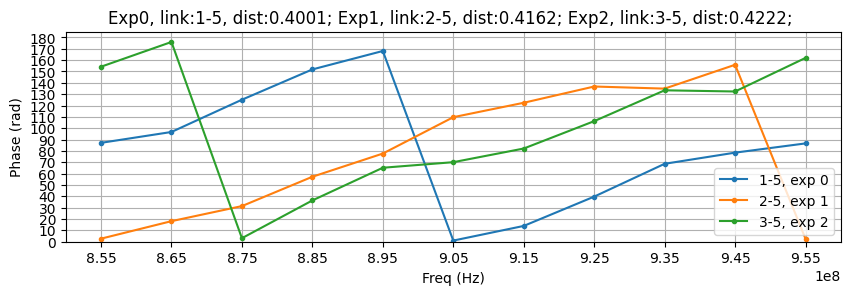

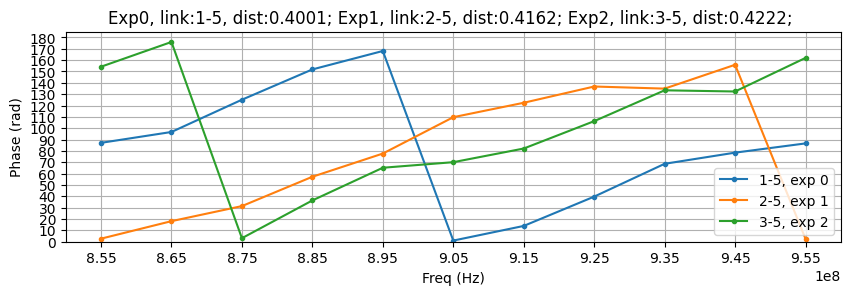

In [36]:
plot_phases(step=1, exps=[0,1,2], links=['1-5','2-5', '3-5'], start_freq_idx=0, end_freq_idx=-1)
plot_phases(step=1, exps=[0,1,2], links=['1-5','2-5', '3-5'])
plot_phases(step=1, exps=[0,1,2], links=['1-5','2-5', '3-5'])

# plot_phases(step=1, exp1=1, exp2=2, link1='2-5', link2='3-5')
# plot_phases(step=1, exp1=2, exp2=3, link1='3-5', link2='4-5')
# plot_phases(step=1, exp1=0, exp2=3, link1='1-5', link2='4-5')

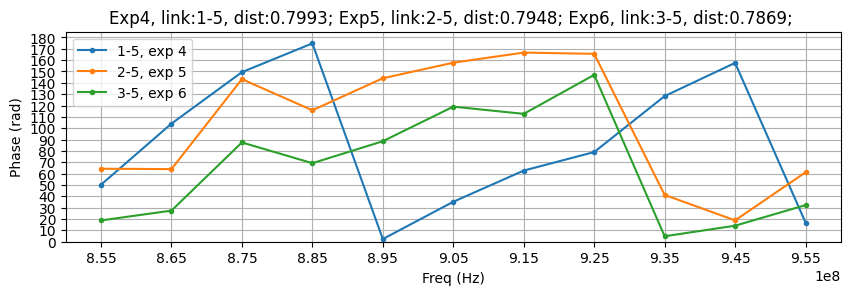

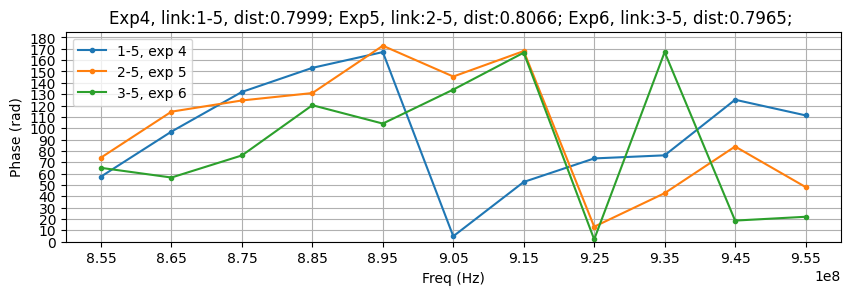

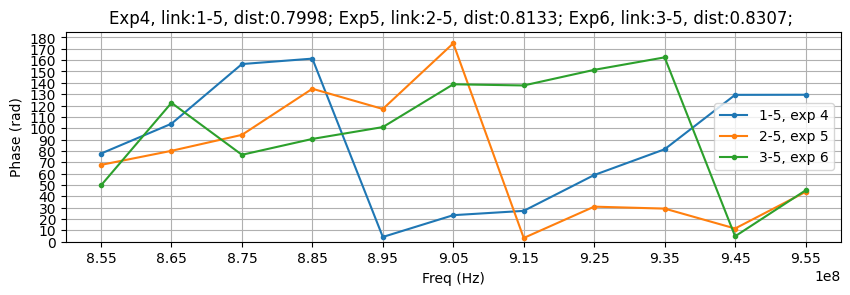

In [37]:
plot_phases(step=1, exps=[4,5,6], links=['1-5','2-5', '3-5'])
plot_phases(step=2, exps=[4,5,6], links=['1-5','2-5', '3-5'])
plot_phases(step=3, exps=[4,5,6], links=['1-5','2-5', '3-5'])

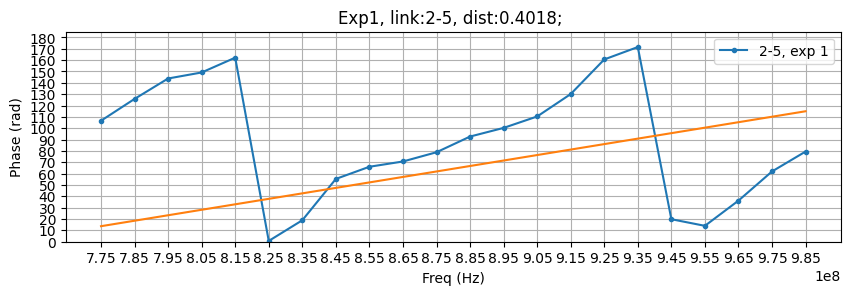

In [107]:
ph, ph_th=plot_phases(step=2, exps=[1], links=['2-5'],start_freq_idx=0, end_freq_idx=-1)


Dist: 1.0638676176570856
Dist Th: 0.4018000000000025


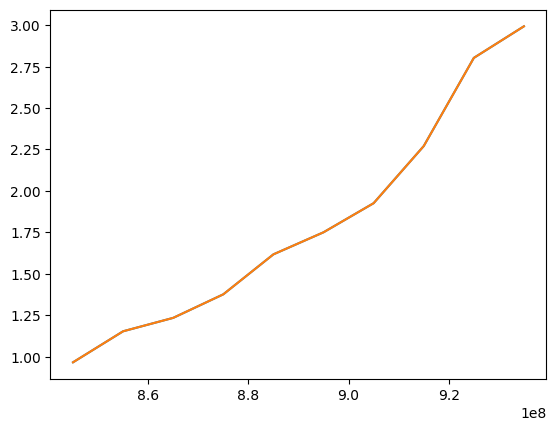

In [108]:
phases=list(ph.values())[0][7:17]
phases_th=ph_th[7:17]
freqs=np.arange(775,1000,10)*1e6
freqs=freqs[7:17]
phases_uwrap=np.unwrap(phases, period=np.pi)
coef=np.polyfit(freqs, phases_uwrap,1)
slope=coef[0]

phases_unwrapth=np.unwrap(phases_th, period=np.pi)
coef_th=np.polyfit(freqs, phases_unwrapth,1)
slope_th=coef_th[0]

dist=(3e8/(2*np.pi))*slope
dist_th=(3e8/(2*np.pi))*slope_th
print("Dist:",dist)
print("Dist Th:",dist_th)
plt.plot(freqs,phases)
plt.plot(freqs,phases_uwrap)

In [39]:
# plot_phases(step=1, exp1=4, exp2=5, link1='1-5', link2='2-5')
# plot_phases(step=1, exp1=5, exp2=6, link1='2-5', link2='3-5')
# plot_phases(step=1, exp1=6, exp2=7, link1='3-5', link2='4-5')
# # plot_phases(step=1, exp1=0, exp2=3, link1='1-5', link2='4-5')

In [40]:
# plot_phases(step=2, exp1=0, exp2=1, link1='1-5', link2='2-5')
# plot_phases(step=2, exp1=1, exp2=2, link1='2-5', link2='3-5')
# plot_phases(step=2, exp1=2, exp2=3, link1='3-5', link2='4-5')
# # plot_phases(step=1, exp1=0, exp2=3, link1='1-5', link2='4-5')

In [41]:
# plot_phases(step=3, exp1=0, exp2=1, link1='1-5', link2='2-5')
# plot_phases(step=3, exp1=1, exp2=2, link1='2-5', link2='3-5')
# plot_phases(step=3, exp1=2, exp2=3, link1='3-5', link2='4-5')

In [42]:
# plot_phases(step=4, exp1=0, exp2=1, link1='1-5', link2='2-5')
# plot_phases(step=4, exp1=1, exp2=2, link1='2-5', link2='3-5')
# plot_phases(step=4, exp1=2, exp2=3, link1='3-5', link2='4-5')